In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

GPU available


# GPs with cellij
from: https://pyro.ai/examples/gp.html

In [2]:
import torch
import gpytorch
import pyro
import pandas as pd
import numpy as np
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import umap

import cellij

pyro.set_rng_seed(0)

/home/icb/tim.treis/miniconda3/envs/cellij/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/icb/tim.treis/miniconda3/envs/cellij/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/tim.treis/miniconda3/envs/cellij/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is curre

In [3]:
d = "guo"

if d == "guo":
    imp = cellij.core.Importer()
    mdata = imp.load_Guo2010()
    obs = mdata.obs
    adata = mdata["qPCR"]
    X = torch.tensor(adata.to_df().values).float()
    time = obs["division_scaled"]

    label_encoder = LabelEncoder()
    
    # Fill None values with a unique string (e.g., 'NoneValue')
    obs['label'].fillna('NoneValue', inplace=True)
    
    # Fit and transform the label column
    encoded_labels = label_encoder.fit_transform(obs['label'])
    
    # Replace the NoneValue label with 0
    encoded_labels = np.where(obs['label'] == 'NoneValue', 0, encoded_labels)
    
    # Update the DataFrame with the encoded labels
    tissue = encoded_labels/4

    obs_metadata = pd.DataFrame()
    obs_metadata["time"] = time
    obs_metadata["tissue"] = tissue
    
elif d == "mefisto":
    imp = cellij.core.Importer()
    mdata = imp.load_MEFISTO()
    adata = mdata["view1"]
    X = torch.tensor(adata.to_df().values).float()
    time = torch.tensor(np.linspace(0, 1, data.shape[0])).float()

/home/icb/tim.treis/miniconda3/envs/cellij/lib/python3.9/site-packages/mudata/_core/mudata.py:577: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/icb/tim.treis/miniconda3/envs/cellij/lib/python3.9/site-packages/mudata/_core/mudata.py:577: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [23]:


class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, n_factors, init_lengthscale=5.,): 
        n_inducing = len(inducing_points)
        
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=n_inducing, batch_shape = torch.Size([n_factors]),
            )

        variational_strategy = gpytorch.variational.VariationalStrategy(
            model=self, 
            inducing_points=torch.tensor(
                data=inducing_points,
                dtype=torch.float32
            ), 
            variational_distribution=variational_distribution, 
            learn_inducing_locations=False,
        )

        super().__init__(variational_strategy=variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean(
            batch_shape=torch.Size([n_factors]),
            )
        self.kernel = gpytorch.kernels.RBFKernel(batch_shape = torch.Size([n_factors]))
        self.covar_module = gpytorch.kernels.ScaleKernel(self.kernel)
        self.covar_module.base_kernel.lengthscale = init_lengthscale

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



In [34]:


class MEFISTO(gpytorch.Module):
    def __init__(
        self,
        data,
        covariates: pd.DataFrame(),
        n_factors,
        device,
    ):
        super().__init__()
        pyro.clear_param_store()

        self.device = device
        self.n_factors = n_factors
        self.data = data
        self.metadata = torch.Tensor(
            covariates.values,
            device=device,
        ).squeeze() 
        self.inducing_points = torch.Tensor(
            covariates.drop_duplicates().values,
            device=device,
        ).squeeze()
        self.n_obs = self.data.shape[0]
        self.n_features = self.data.shape[1]
        self.to(device)
        
        self.plates = {
            "obs": pyro.plate("obs", self.n_obs, dim=-1, device=self.device),
            "factors": pyro.plate("factors", self.n_factors, dim=-2, device=self.device),
            "features": pyro.plate("features", self.n_features, dim=-3, device=self.device),
        }
        
        print(self.inducing_points.shape)
        self.gp = GPModel(
            inducing_points=self.inducing_points,
            n_factors=self.n_factors
        ).to(device=self.device)

                # self.w_init = _init_pca(self.time, 0) # Initialise X to PCA
        
    def model(self):
        pyro.module("gp", self)
        
        with self.plates["features"], self.plates["factors"]:
            w = pyro.sample(
                "w", 
                pyro.distributions.Normal(
                    torch.tensor(0.0, device=self.device), 
                    torch.tensor(1.0, device=self.device)
                )
            ).to(self.device).view(-1, self.n_features, self.n_factors, 1)

        with self.plates["factors"], self.plates["obs"]:
            z = pyro.sample(
                    "z",
                    self.gp.pyro_model(self.metadata),
                ).to(self.device).view(-1, 1, self.n_factors, self.n_obs)
        
        prod = torch.matmul(
            input=w.squeeze(),
            other=z.squeeze(),
        ).to(self.device).view(-1, self.n_features, 1, self.n_obs)

        with self.plates["features"], self.plates["obs"]:
            pyro.sample(
                name='obs',
                fn=pyro.distributions.Normal(prod, 1.),
                obs=self.data.T.view(-1, self.n_features, 1, self.n_obs),
            ).to(self.device)

    def guide(self):
        w_loc = pyro.param('w_loc',  init_tensor=torch.full(
                size=[self.n_features, self.n_factors],
                fill_value=0.0,
                dtype=torch.float32,
                device=self.device,
            )).view(-1, self.n_features, self.n_factors, 1)
        w_scale = pyro.param('w_scale', init_tensor=torch.full(
                size=[self.n_features, self.n_factors],
                fill_value=1.0,
                dtype=torch.float32,
                device=self.device,
            )).view(-1, self.n_features, self.n_factors, 1)
        
        with self.plates["features"], self.plates["factors"]:
            pyro.sample(
                "w", 
                pyro.distributions.Normal(w_loc, w_scale)
            ).to(self.device).view(-1, self.n_features, self.n_factors, 1)
        
        with self.plates["factors"], self.plates["obs"]:
            pyro.sample(
                    "z",
                    self.gp.pyro_guide(self.metadata),
            ).to(self.device).view(-1, 1, self.n_factors, self.n_obs)

    def inference(self, num_particles=15, max_epochs=1000):
        self.optimizer = pyro.optim.Adam({"lr": 1e-3})

        elbo = pyro.infer.Trace_ELBO(
            retain_graph=True,
            num_particles=num_particles,
            vectorize_particles=True,
        )

        svi = pyro.infer.SVI(
            model=self.model,
            guide=self.guide,
            optim=self.optimizer,
            loss=elbo,
        )

        self.train()
        self.losses = []
        for epoch in range(max_epochs):
            self.zero_grad()
            loss = svi.step()
            self.losses.append(loss)
            if epoch % 100 == 0:
                print(epoch, loss)
                
    def get_factors(
        self,
        n_samples: int=25,
        ) -> torch.tensor:
        """Get the inferred means of the factors.
        
        Args:
            n_samples: number of samples to use for mean estimate

        Returns:
            tensor of shape (n_cells, n_factors, res, res)
        """
        self.eval()
        
        factor_means = []
        with torch.no_grad():
            dist = self.gp(self.metadata)
            samples = dist(torch.Size([n_samples])).cpu()
            mean = samples.mean(dim=0)
            mean = torch.transpose(mean, -1, -2)
            factor_means.append(torch.transpose(mean, -1, -2))

        factor_means = torch.stack(factor_means, dim=0)

        self.train()

        return factor_means

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MEFISTO(data=X, covariates=obs_metadata[["time"]], n_factors=4, device=device)
model.inference(num_particles=10, max_epochs=1)

torch.Size([7])


/tmp/ipykernel_3283859/2149676682.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inducing_points=torch.tensor(


0 57829.1625


In [35]:
model.inference(num_particles=10, max_epochs=10000)

0 59803.18708496094
100 46957.508032226564
200 42764.260424804685
300 38395.586694335936
400 36396.613037109375
500 35463.29052734375
600 34701.75622558594
700 34409.452905273436
800 33783.68947753906
900 33291.4000366211
1000 33064.98034667969
1100 32606.5267578125
1200 32426.573046875
1300 32137.410803222658
1400 31850.01552734375
1500 31608.740759277345
1600 31359.955313110353
1700 31118.152883911134
1800 30900.1373046875
1900 30748.461178588866
2000 30597.52520751953
2100 30476.846069335938
2200 30425.252893066405
2300 30365.78659667969
2400 30324.13380126953
2500 30298.54393310547
2600 30291.052111816407
2700 30279.37373046875
2800 30271.446203613283
2900 30273.147729492186
3000 30266.629162597656
3100 30264.184912109376
3200 30261.856591796874
3300 30262.10986328125
3400 30263.934509277344
3500 30262.802587890626
3600 30259.183349609375
3700 30258.27438964844
3800 30264.61033935547
3900 30252.8609375
4000 30260.652893066406
4100 30257.61037597656
4200 30257.791357421876
4300 3026

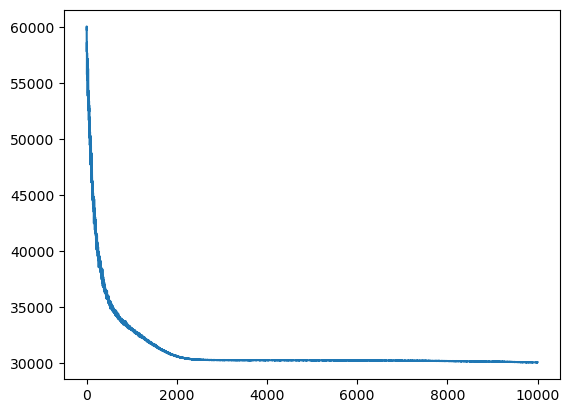

In [36]:
plt.plot(model.losses)

In [8]:
time = torch.tensor(obs_metadata[["time"]].values).float()

In [37]:
factor_means = []
with torch.no_grad():
    dist = model.gp(time)
    samples = dist(torch.Size([10000])).cpu()
    mean = samples.mean(dim=0)
    mean = torch.transpose(mean, -1, -2)
    factor_means.append(torch.transpose(mean, -1, -2))

factor_means = torch.stack(factor_means, dim=0)
factor_means

tensor([[[ 3.9035e-03,  3.9534e-03,  3.9955e-03,  ...,  2.5904e-03,
           2.3577e-03,  2.5331e-03],
         [-1.2053e-03, -1.0466e-03, -1.1313e-03,  ..., -7.3359e-04,
          -9.0738e-04, -7.5196e-04],
         [-1.0910e-03, -1.1096e-03, -8.8444e-04,  ..., -1.1097e-03,
          -1.2925e-03, -1.2184e-03],
         [ 4.6617e-05,  3.2438e-06, -3.3234e-05,  ...,  2.4999e-04,
           1.5208e-04,  2.0148e-04]]], device='cpu')

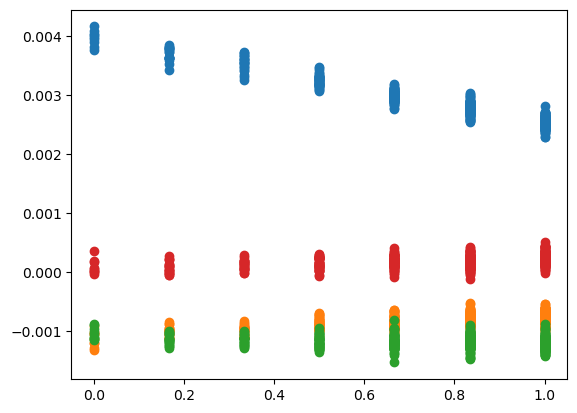

In [38]:
for i in range(4):
    plt.scatter(time.cpu().detach().numpy(), factor_means.squeeze()[i], )

(4, 7)


<Axes: >

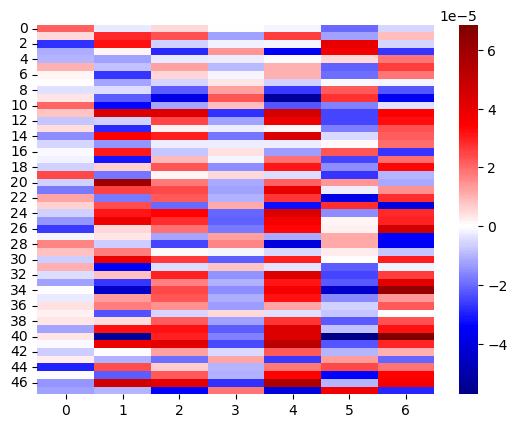

In [39]:
z = pyro.param('gp$$$gp.variational_strategy._variational_distribution.variational_mean').cpu().detach().numpy()
print(f"{z.shape}")
w = pyro.param("w_loc").squeeze().cpu().detach().numpy()
sns.heatmap(w@z, center=0, cmap="seismic")

<Axes: >

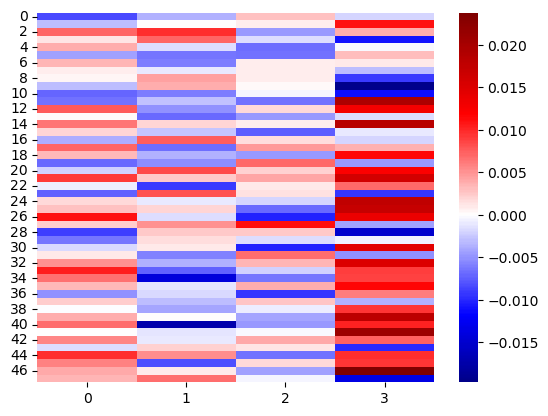

In [40]:
sns.heatmap(w, center=0, cmap="seismic")

In [41]:
# Create a UMAP object with desired parameters
umap_obj = umap.UMAP()

# Fit the UMAP model to your matrix
umap_result = umap_obj.fit_transform(factor_means.squeeze().T)


             0          1  time      label
0     0.056149   0.579481   0.0  NoneValue
1     0.073169   0.615615   0.0  NoneValue
2     0.056212   0.563750   0.0  NoneValue
3    -0.039447   0.512554   0.0  NoneValue
4    -0.006419   0.529888   0.0  NoneValue
..         ...        ...   ...        ...
432   9.999249  10.419744   1.0         TE
433  10.314237  10.313334   1.0         TE
434  10.163079   8.899461   1.0         TE
435  10.342682  10.893126   1.0         TE
436  11.327597   8.187201   1.0         TE

[437 rows x 4 columns]


/tmp/ipykernel_3283859/791722958.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', num_labels)


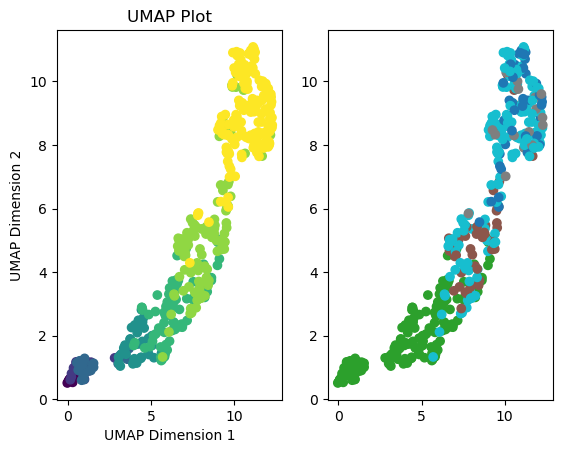

In [42]:
umap_result = pd.DataFrame(umap_result)
umap_result["time"] = mdata.obs["division_scaled"].values
umap_result["label"] = mdata.obs["label"].values
print(umap_result)

label_set = set(umap_result["label"]) - {None}
num_labels = len(label_set)
color_map = plt.cm.get_cmap('tab10', num_labels)
label_to_color = {label: color_map(i) for i, label in enumerate(label_set)}

# Assign colors to the points based on the labels
colors = [label_to_color[label] if label in label_to_color else 'gray' for label in umap_result["label"]]

fig, axs = plt.subplots(ncols=2, nrows=1)
axs[0].scatter(umap_result[0], umap_result[1], c = umap_result["time"])
axs[0].set_xlabel('UMAP Dimension 1')
axs[0].set_ylabel('UMAP Dimension 2')
axs[0].set_title('UMAP Plot')

axs[1].scatter(umap_result[0], umap_result[1], c = colors)


In [15]:
sns.heatmap(d.squeeze(), center=0, cmap="seismic")

AttributeError: 'str' object has no attribute 'squeeze'

In [ ]:
sns.heatmap(w.squeeze(), center=0, cmap="seismic")

In [ ]:
print(

np.array(d.T.squeeze())[:, 1] @  w[:, 1]

In [ ]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

test_x = torch.linspace(0, 1, 100).float()

model.eval()
with torch.no_grad():
    output = model.gp(test_x)

samples = output(torch.Size([1000]))
lower, mean, upper = percentiles_from_samples(samples)

In [ ]:
for k in range(2):
    # visualize the result
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    line, = ax.plot(test_x, mean[k].detach().cpu().numpy(), label='GP prediction')
    ax.fill_between(
        test_x, lower[k].detach().cpu().numpy(),
        upper[k].detach().cpu().numpy(), color=line.get_color(), alpha=0.5
    )

In [ ]:
plt.plot(